In [1]:
from util.graph import Graph
from util.benchmark_parser import WorkerBenchmarkParser
import random
import statistics

In [ ]:
bpath = r'instances/Example_Instances_FJSSP-WF'

In [ ]:
# This is an example solution of the Fattahi20 FJSSP-W instance
s = [0, 201, 341, 503, 198, 397, 610, 727, 0, 61, 244, 341, 0, 79, 470, 701, 79, 316, 760, 997, 603, 765, 886, 994, 93, 250, 397, 994, 224, 485, 779, 1008, 593, 760, 963, 1010, 0, 224, 455, 634, 457, 596, 836, 874, 61, 389, 596, 779]
m = [2, 6, 4, 7, 0, 1, 5, 4, 1, 6, 4, 7, 0, 4, 3, 5, 0, 6, 1, 7, 3, 2, 4, 3, 2, 2, 6, 4, 3, 4, 6, 6, 1, 3, 6, 5, 3, 5, 5, 7, 1, 2, 4, 5, 1, 2, 6, 7]
w = [0, 9, 2, 5, 11, 0, 10, 6, 1, 8, 2, 6, 7, 10, 0, 5, 9, 3, 8, 5, 8, 4, 11, 9, 3, 8, 11, 4, 7, 1, 9, 2, 7, 1, 8, 8, 5, 1, 4, 0, 3, 9, 6, 7, 4, 9, 11, 3]

parser = WorkerBenchmarkParser()
encoding = parser.parse_benchmark(bpath + '/' + 'Fattahi20.fjs')
instance = {
    's': s,
    'm': m,
    'w': w,
    'd': encoding.durations(),
    'js': encoding.job_sequence()
}

# The implemented graph class requires the ending times for the simulations
e = [instance['s'][i]+instance['d'][i][instance['m'][i]][instance['w'][i]] for i in range(len(instance['s']))]
instance['e'] = e

In [4]:
# The Graph class expects the starting times 's', the ending times 'e', the machine assignments 'm', the worker assignments 'w', and the job sequence 'js'. 
# The optional parameter 'leftshift' : bool = False disables possible leftshifts (if the probability distribution allows for faster operation finished instead of only delays, the graph can compensate by adjusting the operations to an earlier starting time.)
# The optional parameter 'buffers' : list[float] = [] allows to add planned buffer times if they are part of the optimization process. The buffer times here are given as a percentage of the operations duration. If buffer times are given, the vector needs to have the same
# length as the sequence vector.
g = Graph(instance['s'], e, instance['m'], instance['w'], instance['js'])

In [5]:
n_workers = max(w)+1
uncertainty_parameters = []
# In this example, a different distribution is used for every worker to simulate inconsistent working times.
# Note that the probability distribution used in the simulation to determine the real durations uses a beta-distribution.
for i in range(n_workers):
    alpha = random.random()
    beta = 10 * alpha
    offset = min(1.0 + random.random(), 1.0)
    uncertainty_parameters.append([alpha, beta, offset])

In [6]:
# Alternatively to the above, the uncertainty parameters can also be created by a util function
from util.uncertainty import create_uncertainty_vector
# The function create_uncertainty_vector has 2 optional parameters
# The optional parameter 'factor' : float = 10.0 determines the ratio of alpha and beta for the used beta distribution beta = alpha * factor
# The default value 10.0 creates distributions that favor many smaller deviations and only few large delays caused by the workers
# The optional parameter 'offset' : float = 1.0 can be used to enforce an offset for the processing times, where e.g. offset = 1.1 would cause all processing times
# to be at least 10% longer than the original processing times
uncertainty_parameters = create_uncertainty_vector(n_workers)

In [7]:
print(f'Original Fitness: {max(g.e)}')

Original Fitness: 1147


In [8]:
# The options for running uncertainties are:
# - processing_times: adds noise the processing times according to the uncertainty parameters
# - machine_breakdowns: generates random events to simulate machine breakdowns
# - worker_unavailabilities: generates random events to simulate worker unavailabilities
g.simulate(instance['d'], uncertainty_parameters, processing_times=True)

44

In [9]:
print(f'Fitness after applied uncertainties: {max(g.e)}')

Fitness after applied uncertainties: 2445.1163077393085


In [10]:
# This example shows how the Graph class is used to run multiple simulations to gather multiple results to account for the random nature of the uncertainties
results = []
n_simulations = 30
for i in range(n_simulations):
    g = Graph(instance['s'], e, instance['m'], instance['w'], instance['js'])
    g.simulate(instance['d'], uncertainty_parameters, processing_times=True)
    results.append(float(max(g.e)))

robust_makespan = statistics.mean(results)
robust_makespan_stdev = statistics.stdev(results)
R = robust_makespan/max(e)

print(f'Original Makespan: {max(e)} | Robust Makespan: {robust_makespan:.4f} - {robust_makespan_stdev:.4f} | Original-Robust Relation: {R:.4f}')

Original Makespan: 1147 | Robust Makespan: 2464.3135 - 53.0498 | Original-Robust Relation: 2.1485


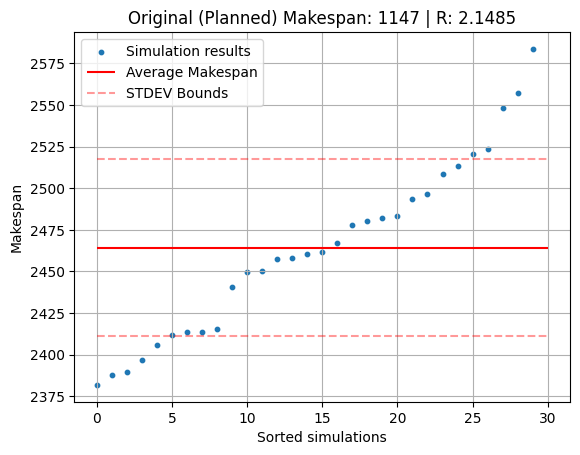

In [11]:
from util.visualization import show_simulation_results
# The visualization requires some information about the instance as dict (specifically the end times "e" need to be present to determine the original makespan and "R") and the result list of the simulation runs.
show_simulation_results(instance, results)

In [12]:
# If no special case or additional processing needs to be handled other than plainly running the simulation n-times, this can also be abbreviated
from util.graph import run_n_simulations
n_simulations = 100
results, robust_makespan, robust_makespan_stdev, R = run_n_simulations(instance['s'], e, instance['m'], instance['w'], instance['js'], instance['d'], uncertainty_parameters, n_simulations, processing_times=True)
print(f'Original Makespan: {max(e)} | Robust Makespan: {robust_makespan:.4f} - {robust_makespan_stdev:.4f} | Original-Robust Relation: {R:.4f}')

Original Makespan: 1147 | Robust Makespan: 2467.4163 - 52.2714 | Original-Robust Relation: 2.1512


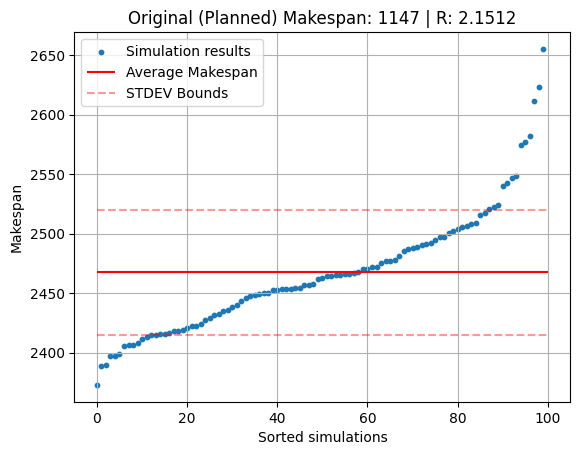

In [13]:
from util.visualization import show_simulation_results
show_simulation_results(instance, results)

In [14]:
# To compare different methods, here illustrated by different simulation runs
from util.graph import run_n_simulations
n_simulations = 100
resultsA, robust_makespanA, robust_makespan_stdevA, RA = run_n_simulations(instance['s'], e, instance['m'], instance['w'], instance['js'], instance['d'], uncertainty_parameters, n_simulations, processing_times=True)
print(f'Original Makespan: {max(e)} | Robust Makespan: {robust_makespanA:.4f} - {robust_makespan_stdevA:.4f} | Original-Robust Relation: {RA:.4f}')

# As an optional parameter, the source of the uncertainties can be attached to either the workers or the machines by setting the paramter uncertainty_source : str to either 'worker' or 'machine'
resultsB, robust_makespanB, robust_makespan_stdevB, RB = run_n_simulations(instance['s'], e, instance['m'], instance['w'], instance['js'], instance['d'], uncertainty_parameters, n_simulations, uncertainty_source = 'worker', processing_times=True)
print(f'Original Makespan: {max(e)} | Robust Makespan: {robust_makespanB:.4f} - {robust_makespan_stdevB:.4f} | Original-Robust Relation: {RB:.4f}')

Original Makespan: 1147 | Robust Makespan: 2466.8238 - 60.1489 | Original-Robust Relation: 2.1507
Original Makespan: 1147 | Robust Makespan: 2467.7261 - 47.8303 | Original-Robust Relation: 2.1515


In [15]:
# An example that attaches the uncertainties to the machines of the production environment instead
n_simulations = 100
resultsC, robust_makespanC, robust_makespan_stdevC, RC = run_n_simulations(instance['s'], e, instance['m'], instance['w'], instance['js'], instance['d'], uncertainty_parameters, n_simulations, uncertainty_source='machine', processing_times=True)
print(f'Original Makespan: {max(e)} | Robust Makespan: {robust_makespanC:.4f} - {robust_makespan_stdevC:.4f} | Original-Robust Relation: {RA:.4f}')


Original Makespan: 1147 | Robust Makespan: 2472.1846 - 55.5007 | Original-Robust Relation: 2.1507


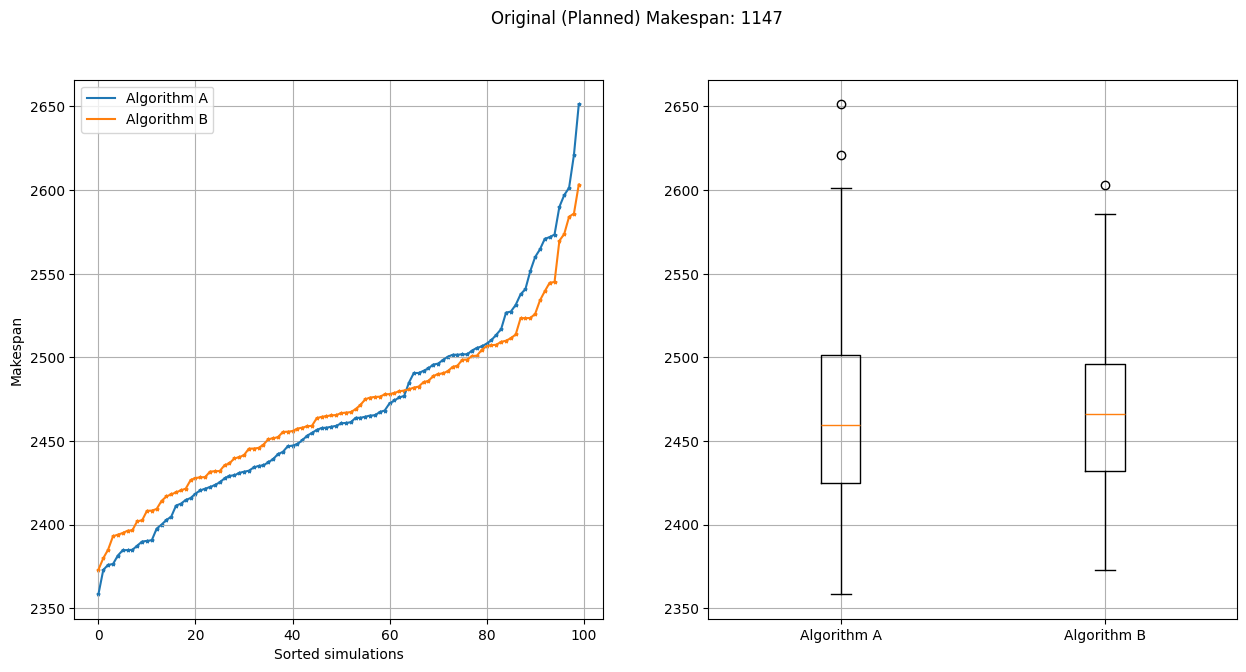

In [16]:
# The comparison can be visualized using the show_simulation_comparison function
# The function expects the list of the results, the labels for the plot, and some information about the problem instance
from util.visualization import show_simulation_comparison
show_simulation_comparison((resultsA, resultsB), ('Algorithm A', 'Algorithm B'), instance)

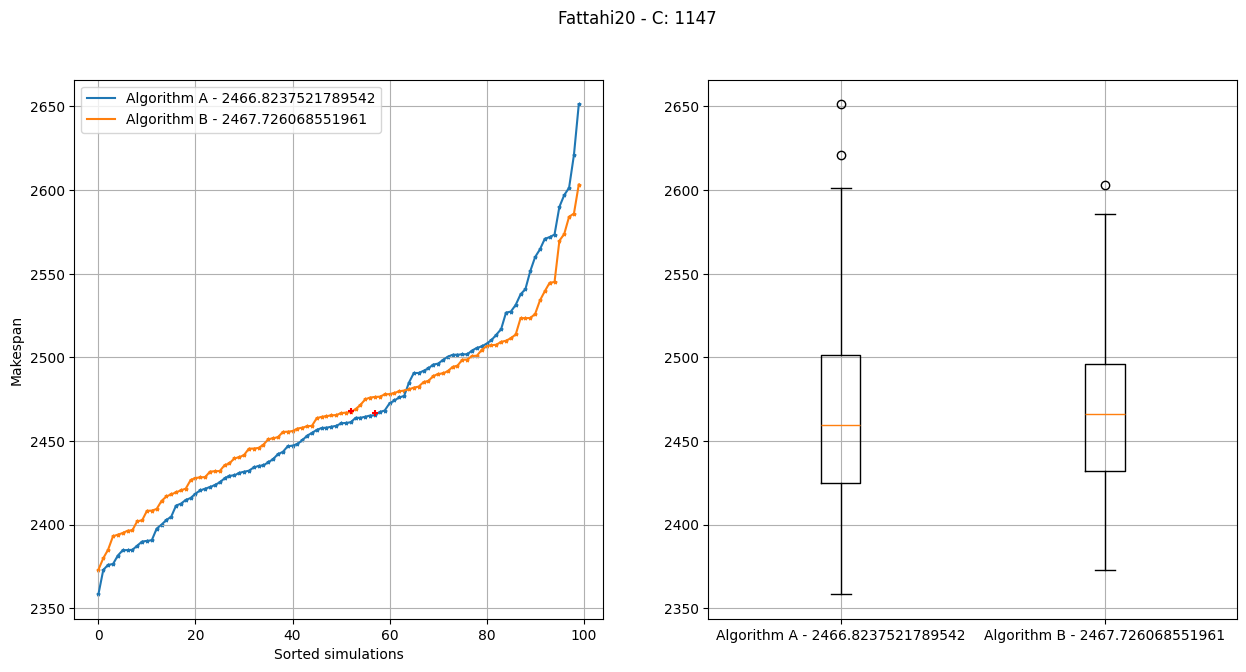

In [17]:
# The title of the plot can be changed using the optional parameter title : str
# An additional optional parameter (mark_average : bool) is available to mark the average makespans
show_simulation_comparison((resultsA, resultsB), (f'Algorithm A - {robust_makespanA}', f'Algorithm B - {robust_makespanB}'), instance, title=f'Fattahi20 - C: {max(e)}', mark_average=True)